#Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import torch.nn.functional as F
import cv2
import random
from torch.utils.data import DataLoader
from google.colab import drive
import torchvision.transforms as T

In [ ]:
# Check if CUDA is available
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset class names
class_names = ['NORMAL', 'PNEUMONIA']


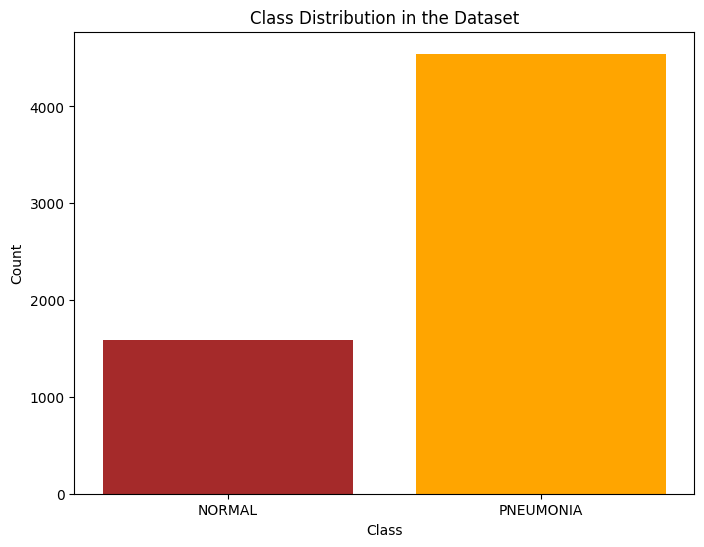

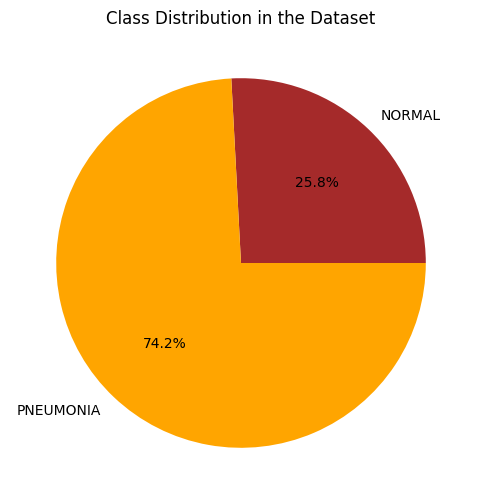

In [ ]:
# Class names and their corresponding counts
class_counts = [1583,4544]  # Replace with actual counts


# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=['brown', 'orange'])
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', colors=['brown', 'orange'])
plt.title('Class Distribution in the Dataset')
plt.show()

In [ ]:
# Dataset paths
TEST_ROOT = "/content/drive/MyDrive/Research /chest_xray/test"
TRAIN_ROOT = "/content/drive/MyDrive/Research /chest_xray/train"

In [ ]:
# # Define data transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # resize ⬅ adjust if your model expects a different size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Validation/Test: resize + center‑crop (no augmentation) + normalize
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [ ]:
# Define data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # resize ⬅ adjust if your model expects a different size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Validation/Test: resize + center‑crop (no augmentation) + normalize
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT, transform=train_transform)
test_dataset  = torchvision.datasets.ImageFolder(root=TEST_ROOT,  transform=val_test_transform)

print("Number of images in training dataset:", len(train_dataset))
print("Number of images in testing dataset:", len(test_dataset))

Number of images in training dataset: 5271
Number of images in testing dataset: 585


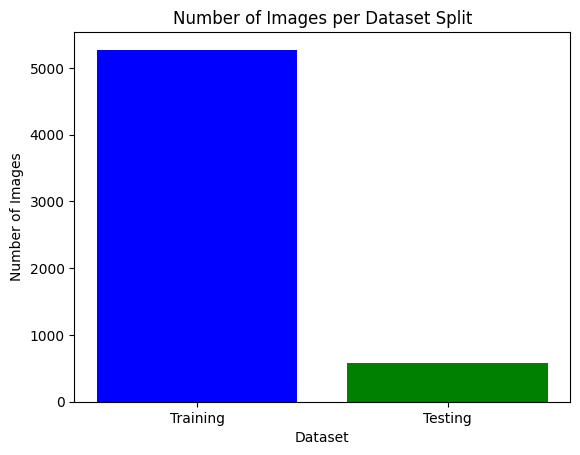

In [ ]:
# ---------------------------------------------
# 1️⃣  Count images in each split
# ---------------------------------------------
training_images    = len(train_dataset)
testing_images     = len(test_dataset)

# ---------------------------------------------
# 2️⃣  Bar‑chart
# ---------------------------------------------
labels = ['Training', 'Testing']
data   = [training_images, testing_images]

plt.bar(labels, data, color=['blue', 'green'])
plt.title('Number of Images per Dataset Split')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.show()

Training samples


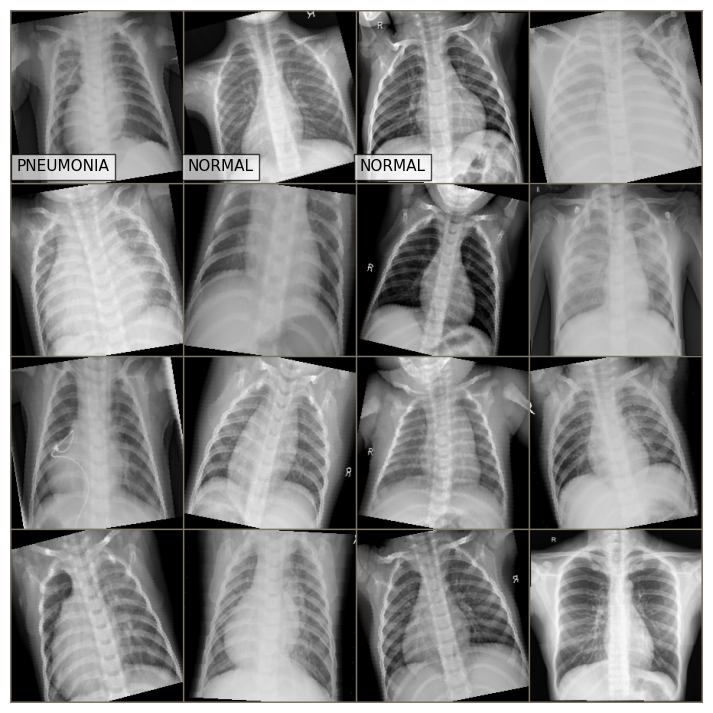

Testing samples


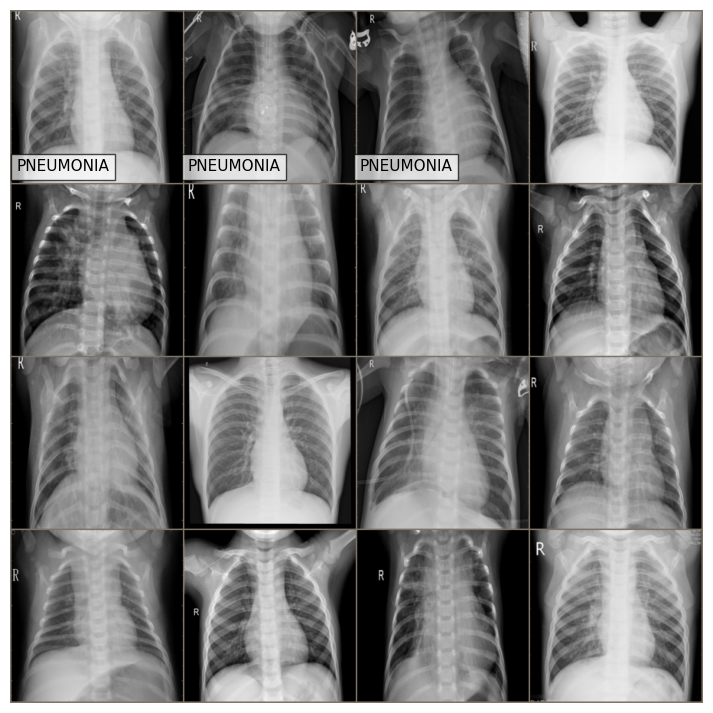

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# -------------------------------------------------
# 1️⃣  Helper to un‑normalise tensors
# -------------------------------------------------
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def unnormalize(batch):
    """Undo transforms.Normalize(mean, std) done earlier."""
    return batch * IMAGENET_STD + IMAGENET_MEAN

# -------------------------------------------------
# 2️⃣  Grid‑plot with class labels
# -------------------------------------------------
def imshow_with_labels(imgs, labels, class_names):
    imgs = unnormalize(imgs)          # ← correct un‑normalisation
    npimg = imgs.numpy()
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis("off")

    for i in range(imgs.size(0)):
        row, col = divmod(i, 4)
        ax.text(
            col * 224 + 8,
            row * 224 + 210,
            class_names[labels[i]],
            bbox=dict(facecolor="white", alpha=0.7),
            fontsize=11,
            color="black",
        )
    plt.show()

def show_images_grid_with_labels(dataset, class_names, title=""):
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
    images, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(images, nrow=4)
    print(title)          # a small heading in text before the plot
    imshow_with_labels(grid, labels, class_names)

# -------------------------------------------------
# 3️⃣  Preview each split
# -------------------------------------------------
show_images_grid_with_labels(train_dataset, class_names, "Training samples")
show_images_grid_with_labels(test_dataset,  class_names, "Testing samples")

Training samples


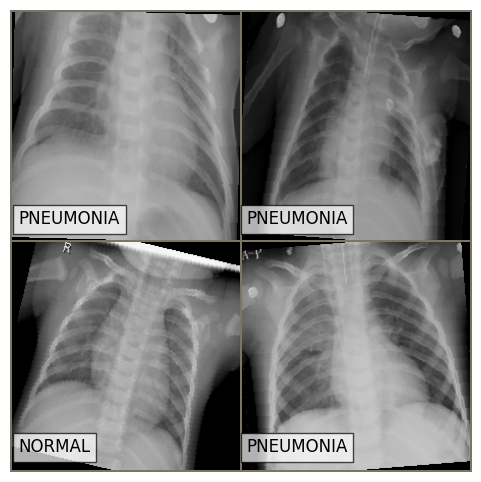

Testing samples


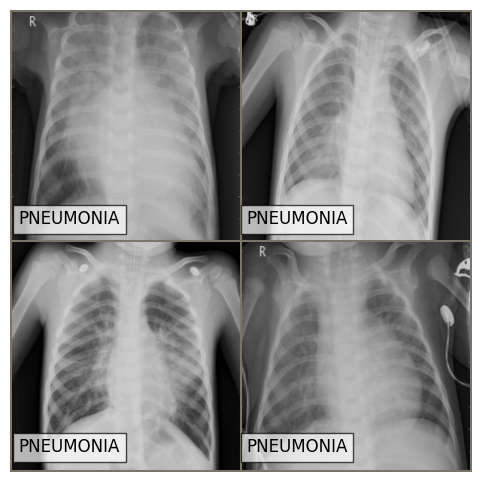

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch
import numpy as np

# -------------------------------------------------
# 1️⃣  Un‑normalise helper (ImageNet stats)
# -------------------------------------------------
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def unnormalize(x):
    """Undo transforms.Normalize(mean, std). Works on a batch or single image."""
    return x * IMAGENET_STD + IMAGENET_MEAN

# -------------------------------------------------
# 2️⃣  Plot a 2 × 2 grid with class labels
# -------------------------------------------------
def imshow_with_labels(imgs, labels, class_names):
    imgs = unnormalize(imgs)                     # ← correct colours
    npimg = imgs.numpy()

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis("off")

    for i in range(labels.size(0)):              # works for any batch size ≤ 4
        row, col = divmod(i, 2)
        ax.text(
            col * 224 + 8,                       # x‑position
            row * 224 + 210,                     # y‑position
            class_names[labels[i]],
            bbox=dict(facecolor="white", alpha=0.7),
            fontsize=12, color="black"
        )
    plt.show()

def show_images_grid_with_labels(dataset, class_names, title=""):
    loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
    images, labels = next(iter(loader))

    print(title)                                 # small heading in output
    grid = torchvision.utils.make_grid(images, nrow=2)
    imshow_with_labels(grid, labels, class_names)

# -------------------------------------------------
# 3️⃣  Preview each split
# -------------------------------------------------
show_images_grid_with_labels(train_dataset, class_names, "Training samples")
show_images_grid_with_labels(test_dataset,  class_names, "Testing samples")

In [ ]:
# Load pre-trained ResNet101 model
resnet101 = models.resnet101(pretrained=True)

# Modify the final fully connected layer to output 2 classes
num_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_features, 2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet101 = resnet101.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:02<00:00, 83.1MB/s]


In [ ]:
from torch.utils.data import DataLoader

# -------------------------------------------------
# 1️⃣  Common settings
# -------------------------------------------------
batch_size  = 16          # keep / change as you like
num_workers = 4           # 0‑4 is safe on Colab; raise if you have CPU headroom
pin_memory  = True        # speeds things up on GPU

# -------------------------------------------------
# 2️⃣  DataLoaders for each split
# -------------------------------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,          # important for SGD!
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# -------------------------------------------------
# 1️⃣  Loss function
# -------------------------------------------------
# Label‑smoothing (0.1) often gives a small but free boost in robustness.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# -------------------------------------------------
# 2️⃣  Optimiser
# -------------------------------------------------
# AdamW is Adam + proper weight‑decay; tends to generalise a bit better.
optimizer = optim.AdamW(
    resnet101.parameters(),
    lr=3e-4,            # start higher; scheduler will drop it on plateaus
    weight_decay=1e-4
)

# -------------------------------------------------
# 3️⃣  LR scheduler (optional but recommended)
# -------------------------------------------------
# Halves the LR if validation loss hasn’t improved for two straight epochs.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# -------------------------------------------------
# 4️⃣  Training epochs
# -------------------------------------------------
num_epochs = 5         # raise or lower as needed

#Training

Epoch 01 | Train L 0.3105 A 93.51% ‖ Test L 0.2827 A 96.24% ✅
Epoch 02 | Train L 0.2791 A 95.52% ‖ Test L 0.2915 A 94.36%   
Epoch 03 | Train L 0.2614 A 96.76% ‖ Test L 0.2981 A 94.36%   
Epoch 04 | Train L 0.2504 A 97.48% ‖ Test L 0.2736 A 96.24% ✅
Epoch 05 | Train L 0.2483 A 97.70% ‖ Test L 0.2793 A 95.04%   
Training finished — best testing loss: 0.2736


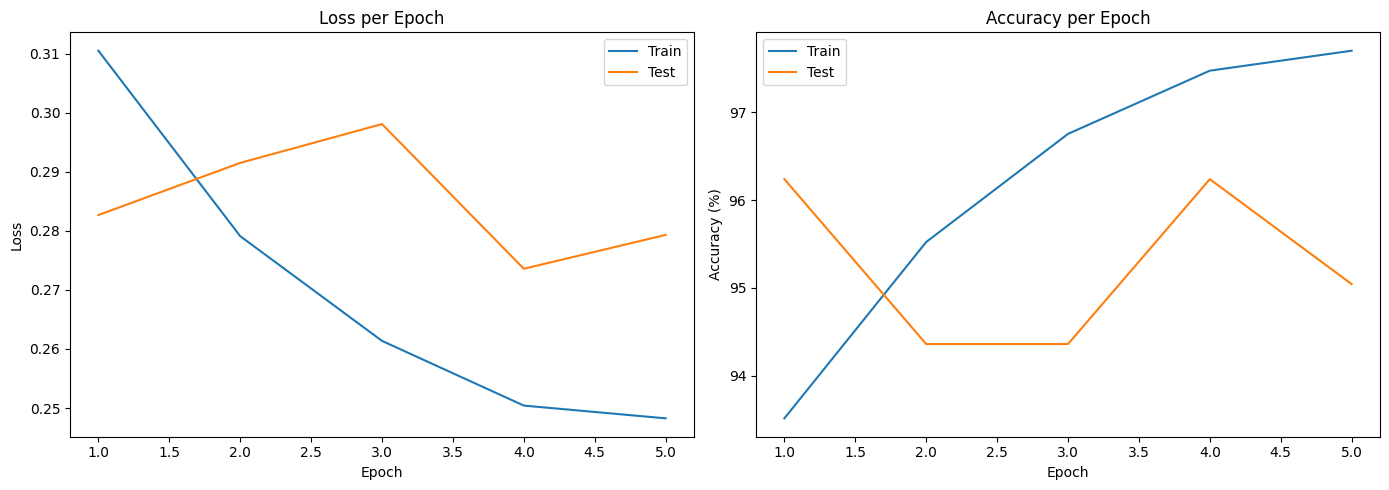

In [ ]:
# ---------------------------------------------
# 0️⃣  Lists for logging
# ---------------------------------------------
train_losses,  test_losses  = [], []
train_accs,    test_accs   = [], []

# ---------------------------------------------
# 1️⃣  Helper: evaluate any split
# ---------------------------------------------
@torch.no_grad()
def evaluate(loader, model, device):
    model.eval()
    running_loss, running_correct = 0.0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss    += loss.item() * inputs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = running_loss / len(loader.dataset)
    acc      = 100.0 * running_correct / len(loader.dataset)
    return acc, avg_loss

# ---------------------------------------------
# 2️⃣  Training loop
# ---------------------------------------------
best_test_loss = float("inf")
ckpt_path     = "best_resnet101_Disease.pth"

for epoch in range(1, num_epochs + 1):
    resnet101.train()
    running_loss, running_correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet101(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * inputs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()

    # ▸ Metrics for this epoch
    train_loss = running_loss / len(train_loader.dataset)
    train_acc  = 100.0 * running_correct / len(train_loader.dataset)
    test_acc, test_loss = evaluate(test_loader, resnet101, device)

    # ▸ LR scheduler step (if you added one)
    if 'scheduler' in globals():
        scheduler.step(test_loss)

    # ▸ Save best checkpoint
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(resnet101.state_dict(), ckpt_path)
        improved = "✅"
    else:
        improved = "  "

    # ▸ Log
    train_losses.append(train_loss); test_losses.append(test_loss)
    train_accs.append(train_acc);    test_accs.append(test_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train L {train_loss:.4f} A {train_acc:5.2f}% ‖ "
          f"Test L {test_loss:.4f} A {test_acc:5.2f}% {improved}")

print(f"Training finished — best testing loss: {best_test_loss:.4f}")


# ---------------------------------------------
# 3️⃣  Curves
# ---------------------------------------------
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, test_losses,  label="Test")
plt.title("Loss per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train")
plt.plot(epochs, test_accs,  label="Test")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Rebuild same model architecture
resnet101 = models.resnet101(pretrained=False)
num_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_features, 2)   # binary classification

# Load your trained weights
ckpt_path = "best_resnet101_Disease.pth"
resnet101.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
resnet101.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# ✅ Step 1: Define model with correct final layer
resnet101 = models.resnet101(pretrained=False)
num_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_features, 2)   # 2 classes: NORMAL / PNEUMONIA

# ✅ Step 2: Load trained weights (.pth) if you already trained
pth_path = "best_resnet101_Disease.pth"
resnet101.load_state_dict(torch.load(pth_path, map_location="cpu"))
resnet101.eval()

# ✅ Step 3: Convert directly to TorchScript
dummy_input = torch.randn(1, 3, 224, 224)
traced_model = torch.jit.trace(resnet101, dummy_input)

# ✅ Step 4: Save as .pt
pt_path = "/content/drive/MyDrive/Saved Model/resnet101_trained.pt"
traced_model.save(pt_path)

print(f"🔥 TorchScript model saved at: {pt_path}")


🔥 TorchScript model saved at: /content/drive/MyDrive/Saved Model/resnet101_trained.pt


Saving NORMAL-71482-0001.jpeg to NORMAL-71482-0001.jpeg
Prediction: NORMAL (96.52% confidence)


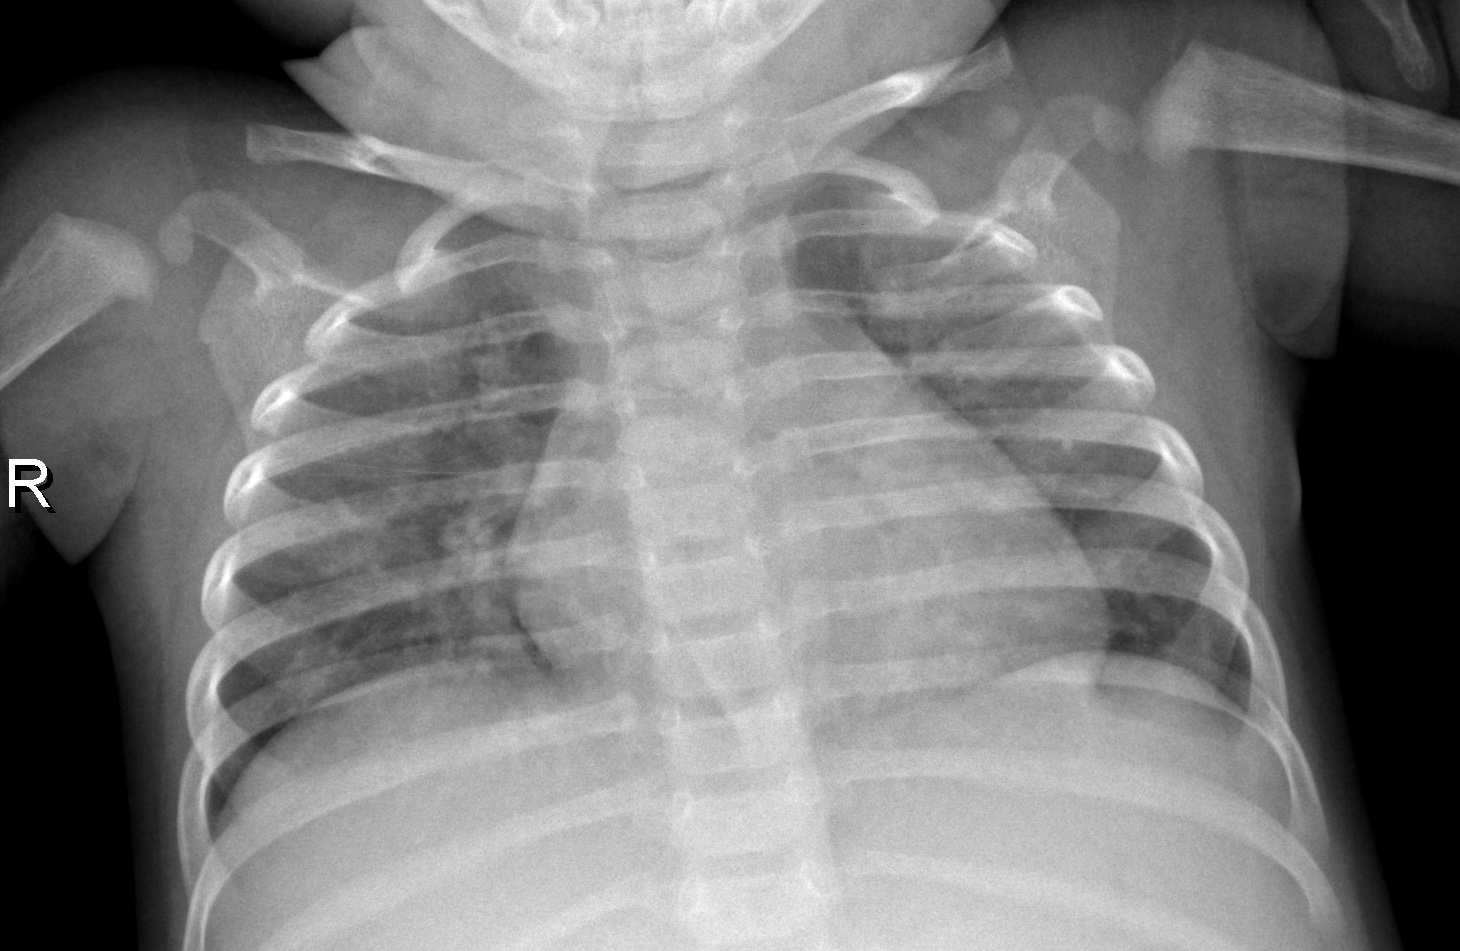

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from google.colab import files

# ✅ Load TorchScript model
model_path = "/content/drive/MyDrive/Saved Model/resnet101_trained.pt"
model = torch.jit.load(model_path, map_location="cpu")
model.eval()

# ✅ Class labels
classes = ["NORMAL", "PNEUMONIA"]

# ✅ Preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Upload image
uploaded = files.upload()
for filename in uploaded.keys():
    img_path = filename
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # [1,3,224,224]

    # ✅ Prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        pred_idx = probs.argmax(1).item()
        confidence = probs[0][pred_idx].item()

    print(f"Prediction: {classes[pred_idx]} ({confidence*100:.2f}% confidence)")
    display(image)


# Training Confusion Matrix and Testing Confusion Matrix

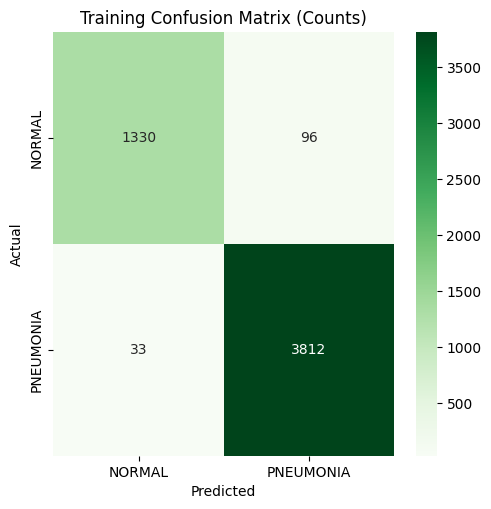

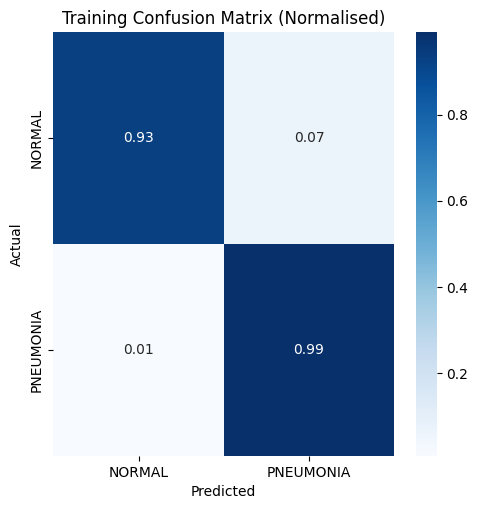

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


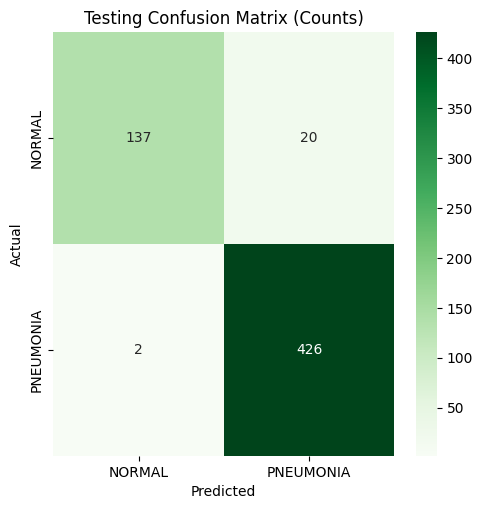

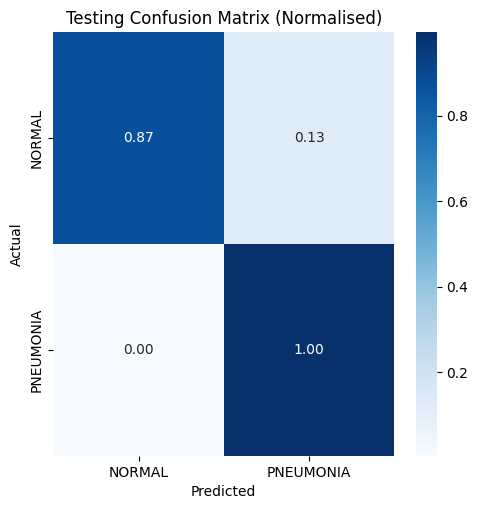

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



===== TEST‑SET CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

      NORMAL       0.99      0.87      0.93       157
   PNEUMONIA       0.96      1.00      0.97       428

    accuracy                           0.96       585
   macro avg       0.97      0.93      0.95       585
weighted avg       0.96      0.96      0.96       585



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Load best weights
BEST_CKPT = "best_resnet101_Disease.pth"   # change if you used a different name
resnet101.load_state_dict(torch.load(BEST_CKPT, map_location=device))
resnet101.eval()

# 2️⃣ Helpers
def calc_cm(loader):
    """Return confusion‑matrix counts (rows = true, cols = pred)."""
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = resnet101(x)
            y_pred.extend(logits.argmax(1).cpu().numpy())
            y_true.extend(y.cpu().numpy())
    return confusion_matrix(y_true, y_pred), y_true, y_pred

def plot_cm(cm, classes, title, normalize=False, cmap="Greens"):
    """Plot a confusion matrix (counts or row‑normalised)."""
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        fmt, cmap = ".2f", "Blues"
    else:
        fmt = "d"
    plt.figure(figsize=(5.5, 5.5))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# 3️⃣ Compute & plot for every split
splits = {
    "Training":    train_loader,
    "Testing":     test_loader,
}

for split_name, loader in splits.items():
    cm, _, _ = calc_cm(loader)
    plot_cm(cm, class_names, f"{split_name} Confusion Matrix (Counts)")
    plot_cm(cm, class_names, f"{split_name} Confusion Matrix (Normalised)", normalize=True)

# 4️⃣ Detailed classification report on the test set
_, y_true_test, y_pred_test = calc_cm(test_loader)
print("\n===== TEST‑SET CLASSIFICATION REPORT =====")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))
# ===========================================================================

#Grad-CAM (Gradient-weighted Class Activation Mapping)

In [ ]:
import torch
import torch.nn.functional as F

def apply_gradcam_resnet101(model, image, target_class, device):
    def hook_fn(module, input, output):
        nonlocal feature_map
        feature_map = output

    feature_map = None  # To store the activation

    # Register hook on the last convolutional layer of resnet101
    hook = model.features[29].register_forward_hook(hook_fn)

    # Move image to device and add batch dimension
    image = image.unsqueeze(0).to(device)
    model.to(device)
    model.eval()

    # Forward pass
    output = model(image)

    # Backward pass for target class
    model.zero_grad()
    target = output[0, target_class]
    target.backward(retain_graph=True)

    # Get gradients of the output w.r.t. the feature map
    gradients = model.features[29].weight.grad  # Not usually needed for GradCAM
    gradients = torch.autograd.grad(outputs=output[:, target_class], inputs=feature_map)[0]
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight the channels by the importance
    for i in range(feature_map.shape[1]):
        feature_map[:, i, :, :] *= pooled_gradients[i]

    # Create the heatmap
    heatmap = torch.mean(feature_map, dim=1).squeeze()
    heatmap = F.relu(heatmap)

    # Clean up the hook
    hook.remove()

    return heatmap


In [ ]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def show_gradcam_resnet101(model, image, target_class, class_names, device):
    # Ensure the image tensor is on the correct device
    image = image.to(device)

    # Apply Grad-CAM for resnet101
    heatmap = apply_gradcam_resnet101(model, image, target_class, device)

    # Undo normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    image = image * std[:, None, None] + mean[:, None, None]

    # Convert image to numpy
    img = image.cpu().detach().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)

    # Convert heatmap to numpy
    heatmap = heatmap.cpu().detach().numpy()

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Combine heatmap with original image
    combined = np.float32(img) + heatmap
    combined = np.clip(combined, 0, 1)

    # Show the image
    plt.imshow(combined)
    plt.title(f"Grad-CAM for {class_names[target_class]}")
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_h

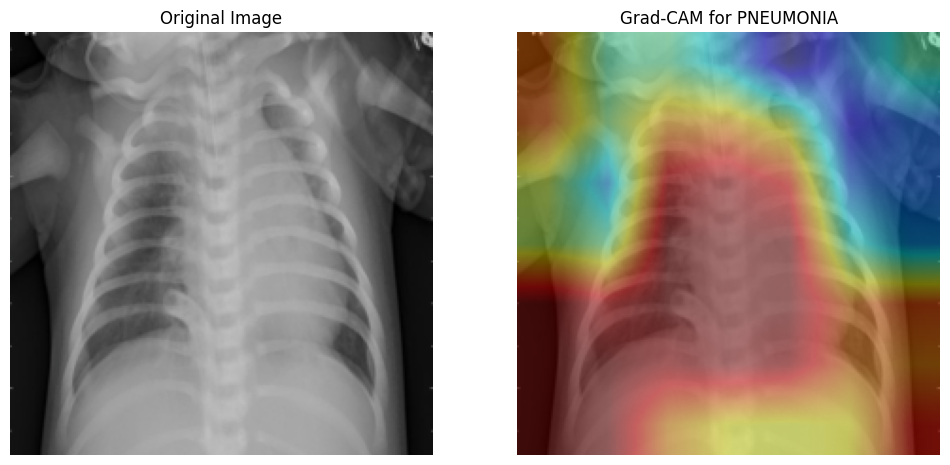

In [ ]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import random
from torchvision import models

# Grad-CAM implementation for resnet101
def apply_gradcam_resnet101(model, image, target_class, device):
    feature_map = None
    gradient = None

    def forward_hook(module, input, output):
        nonlocal feature_map
        feature_map = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradient
        gradient = grad_out[0]

    # Register hooks on the last convolutional layer of resnet101
    # target_layer = model.features[28]  # This is Conv2d, not ReLU
    target_layer = model.layer4[-1].conv3
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.eval()
    image = image.unsqueeze(0).to(device)
    output = model(image)

    # Backward pass for target class
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Pool gradients and compute Grad-CAM
    pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])
    for i in range(feature_map.shape[1]):
        feature_map[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(feature_map, dim=1).squeeze()
    heatmap = torch.relu(heatmap)

    handle_forward.remove()
    handle_backward.remove()

    return heatmap


# Updated show_gradcam for resnet101
def show_gradcam(model, image, target_class, class_names, device):
    image = image.to(device)

    # Apply Grad-CAM (now resnet101-specific)
    heatmap = apply_gradcam_resnet101(model, image, target_class, device)

    # Undo normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    image = image * std[:, None, None] + mean[:, None, None]

    # Convert image to numpy
    img = image.cpu().detach().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)

    # Convert and normalize heatmap
    heatmap = heatmap.cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

    # Resize and apply colormap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Blend image and heatmap
    combined = np.float32(img) * 0.6 + heatmap * 0.4
    combined = np.clip(combined, 0, 1)

    # Plot original and Grad-CAM image
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(combined)
    axes[1].set_title(f"Grad-CAM for {class_names[target_class]}")
    axes[1].axis('off')
    plt.show()


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet101 = models.resnet101(pretrained=True).to(device)
resnet101.eval()

random_idx = random.randint(7, len(test_dataset) - 1)
test_image, test_label = test_dataset[random_idx]

# Show Grad-CAM visualization with original image
show_gradcam(resnet101, test_image, test_label, class_names, device)
